# Transfer Learning with TensorFlow part 2: Fine-Tuning

 In the previous notebook, we covered transfer earning feature extraction. Now it's time to learn about a new kind of transfer learning fine tuning

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-04-02 13:41:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-02 13:41:41 (95.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import hepler functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem (recognizing images of food).

https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-04-02 13:41:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  19.1MB/s    in 9.6s    

2023-04-02 13:41:55 (16.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
unzip_data("10_food_classes_10_percent.zip")

In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
# Create training and test directory paths
train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"

In [7]:
import tensorflow as tf
IMG_SIZE=(224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[194.84996   157.4214    157.77853  ]
   [223.08067   186.5652    186.56505  ]
   [249.10475   216.95822   216.67252  ]
   ...
   [104.34604    87.64822    88.90538  ]
   [ 91.81036    81.26992    80.09593  ]
   [ 89.49474    79.73295    78.137596 ]]

  [[236.57097   216.17157   214.65546  ]
   [238.8841    218.72514   216.48773  ]
   [248.47003   228.75879   225.17825  ]
   ...
   [ 93.62415    79.854904   79.984215 ]
   [ 87.04811    79.37279    79.75398  ]
   [ 85.97353    79.81218    79.83067  ]]

  [[252.83833   251.31999   246.2803   ]
   [252.39      252.7551    247.65993  ]
   [252.10747   250.35252   245.35252  ]
   ...
   [ 86.183495   72.55184    71.69918  ]
   [ 83.65098    76.68166    77.58648  ]
   [ 84.84374    80.41517    81.20088  ]]

  ...

  [[118.17457   123.17457   100.17457  ]
   [117.563286  122.563286   99.563286 ]
   [116.287926  121.287926   98.287926 ]
   ...
   [  0.         48.131554   62.07367  ]
   [  0.         49.785736   63.       ]
   [ 

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibilit with our models.

In [10]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (the underlying pre-trained patterns aren't updated during the training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50v2 you will need to normalize inputs (don't have to when using efficient net)
x = tf.keras.layers.Rescaling(1./255)(inputs)

# 5.Pass the inputs to base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model")

# 6. Average pool the outputs of the base model (aggregate all the most important niformation, reduce number of computation)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8.Combine the inputs with the outputs into the model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model
history_0 = model_0.fit(train_data_10_percent,
                        steps_per_epoch=len(train_data_10_percent),
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)))

16705208/16705208 [==============================] - 2s 0us/step
Shape after passing inputs through base model
Shape after GlobalAveragePooling2D: (None, 1280)
Epoch 1/5
24/24 [==============================] - 20s 236ms/step - loss: 1.8862 - accuracy: 0.4320 - val_loss: 1.3265 - val_accuracy: 0.7188
Epoch 2/5
24/24 [==============================] - 4s 130ms/step - loss: 1.0966 - accuracy: 0.7787 - val_loss: 0.8585 - val_accuracy: 0.8372
Epoch 3/5
24/24 [==============================] - 4s 130ms/step - loss: 0.7771 - accuracy: 0.8440 - val_loss: 0.6826 - val_accuracy: 0.8503
Epoch 4/5
24/24 [==============================] - 4s 173ms/step - loss: 0.6375 - accuracy: 0.8600 - val_loss: 0.6220 - val_accuracy: 0.8503
Epoch 5/5
24/24 [==============================] - 4s 131ms/step - loss: 0.5397 - accuracy: 0.8827 - val_loss: 0.5489 - val_accuracy: 0.8832


In [11]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 10s 116ms/step - loss: 0.5477 - accuracy: 0.8692


[0.5477033257484436, 0.8691999912261963]

In [12]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [13]:
# Summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

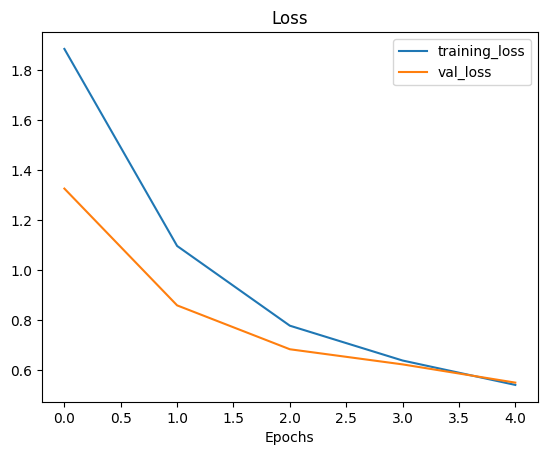

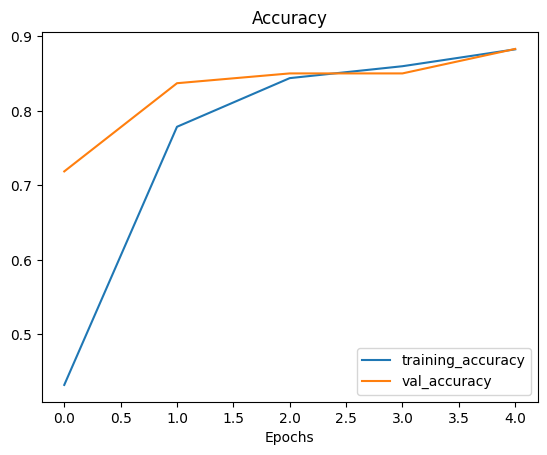

In [14]:
# Check out our model's training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turnd into (None, 1280).

Let's use a similar shapes tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D

In [17]:
# Set random seed
tf.random.set_seed(42)

# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2d layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of different tensors
print(f"shape of input tensor {input_tensor.shape}")
print(f"shape of global average pooled tensor {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

shape of input tensor (1, 4, 4, 3)
shape of global average pooled tensor (1, 3)


In [18]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augumentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augumentation
3. `model_3` - use fine tuning transfer learning on 10% of the training data with data augumentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augumentation

## Getting and preprocessing data for `model_1`

In [26]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-04-02 14:33:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M  24.0MB/s    in 6.4s    

2023-04-02 14:33:53 (19.9 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [27]:
# Create training and test dirs
train_dir_1_percent = "/content/10_food_classes_1_percent/train/"
test_dir = "/content/10_food_classes_1_percent/test/"

In [28]:
# How many images are we working with
walk_through_dir("/content/10_food_classes_1_percent")

There are 2 directories and 0 images in '/content/10_food_classes_1_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '/content/10_food_classes_1_pe

In [29]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=32)

test_dir = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE,
                                                               batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augumentation right into the model

To add data augumentation right into our models, we can use the layers inside:

* `tf.keras.layers`

We can see the benefits of doing this within the TensorFlow Data augumentation documentation

Off the top of our heads, after reading the docs, the benefits of using data augumentation inside the model are:
* Preprocessing of images (augumenting them) happens on the GPU (much faster) rather than on the CPU.
* Image data augumentation only happens during training, so we can still export our whole model and use it elsewhere

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth

# Create data augumentation stage horizontal flipping, rotations, zooms, etc
data_augumentation = keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2),
    # RandomRescale(1./255), # Keep for models like resnet50v2. Unnecessary for efficient net models (they have it built in)
], name="data_augumentation")



### Visualize our data augumentation layer (and see what happens to our data)

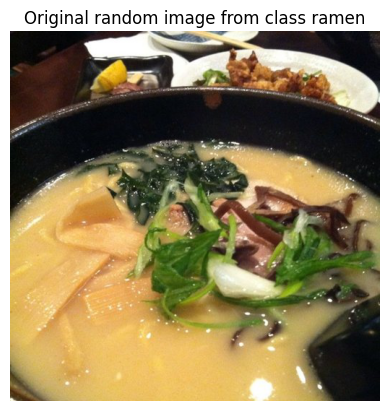

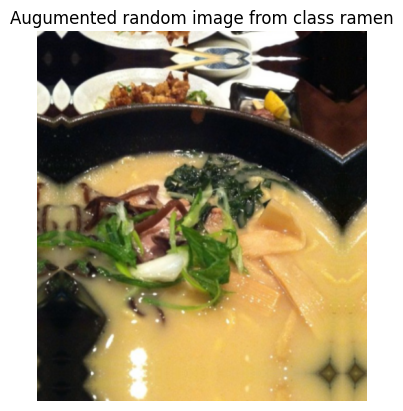

In [37]:
# View a random image and compare it to its augumented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augumented random image
augumented_img = data_augumentation(tf.expand_dims(img, axis=0))

plt.figure()
plt.imshow(tf.squeeze(augumented_img)/ 255.)
plt.title(f"Augumented random image from class {target_class}")
plt.axis(False);